# Des ODE avec Jax ?

In [68]:
%matplotlib ipympl
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import jit, vmap
from dataclasses import dataclass
from jax.tree_util import register_dataclass
from diffrax import ODETerm, Dopri5, SaveAt, PIDController, diffeqsolve

## Problème

On s'intéresse à une paire d'oscillateurs linéaires couplés par une raideur $K_{12}$. 
On voudrait trouver un régime permanent de manière simple, par exemple en simulant quelques périodes d'excitation. 

L'équation différentielle est:

$$
\left \lbrace 
\begin{split}
M_1  \ddot x_1 + D_1  \dot x_1 + K_1  x_1 + K_{12} (x_1 - x_2) = F_{d1} \sin (w_d t)  \\
M_2  \ddot x_2 + D_2  \dot x_2 + K_2  x_1 + K_{12} (x_2 - x_1) = F_{d2} \sin (w_d t) 
\end{split}
\right .
$$


Et d'un point de vue physique, on voudrait connaitre les énergies dissipées par les amortissements $D_1$ et $D_2$ en régime permanent.

:::{note}
Il est possible de simplifier grandement cette équation en l'adimensionnant mais on fait le choix de ne pas le faire ici.
:::

On la traduit comme suit en Python:

1. On crée une classe pour stocker les paramètres du problème. C'est une solution assez pratique pour éviter de passer trop d'arguments à l'ODE et on peut gérer ça de manière transparente avec Jax.


:::{warning}
Les paramètres par défaut sont pris au pif, c'est une mauvaise idée. Si vous avez mieux, dites le moi !
:::

In [69]:
@register_dataclass
@dataclass
class CoupleLinearResonatorParams:
    """
    Parameters for the coupled linear resonator ODE system.
    """

    M1: float = 1.0  # Mass 1
    M2: float = 1.0  # Mass 2
    K1: float = 1.0  # Spring constant 1
    K2: float = 1.0  # Spring constant 2
    K12: float = 0.5  # Coupling spring constant 2
    D1: float = 0.2  # Damping coefficient 1
    D2: float = 0.2  # Damping coefficient 2
    wd: float = 0.5  # Driving frequency
    Fd1: float = 0.5  # Driving force amplitude 1
    Fd2: float = 0.5  # Driving force amplitude 2


ode_params = CoupleLinearResonatorParams(Fd2=0.0)
ode_params

CoupleLinearResonatorParams(M1=1.0, M2=1.0, K1=1.0, K2=1.0, K12=0.5, D1=0.2, D2=0.2, wd=0.5, Fd1=0.5, Fd2=0.0)

2. On écrit l'ODE:

In [70]:
def coupled_linear_resonator_ode(t, X, params: CoupleLinearResonatorParams):
    x1, v1, x2, v2, E1, E2 = X
    dx1dt = v1
    dv1dt = (
        - params.K1 * x1
        - params.K12 * (x1 - x2)
        - params.D1 * v1
        + params.Fd1 * jnp.sin(params.wd * t)
    ) / params.M1
    dx2dt = v2
    dv2dt = (
        - params.K2 * x2
        - params.K12 * (x2 - x1)
        - params.D2 * v2
        + params.Fd2 * jnp.sin(params.wd * t)
    ) / params.M2
    P1 = v1**2 * params.D1
    P2 = v2**2 * params.D2
    return jnp.array([dx1dt, dv1dt, dx2dt, dv2dt, P1, P2])


X0 = jnp.array(
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
)  # Initial state: [x1, v1, x2, v2, E1, E2]
t = 0.2  # Initial time
coupled_linear_resonator_ode(t, X0, ode_params)

Array([0.        , 0.04991671, 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

Ok, notre ODE fonctionne.


3. Essayons de l'intégrer:

In [71]:
term = ODETerm(coupled_linear_resonator_ode)  # Define the ODE term
solver = Dopri5()  # Choose the Dormand-Prince 5(4) solver
t0 = 0.0  # Initial time
t1 = 5.0  # Final time

saveat = SaveAt(ts=[t0, t1])  # Specify time points to save the solution
stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
sol = diffeqsolve(
    term,
    solver,
    t0=t0,
    t1=t1,
    dt0=0.1,
    y0=X0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    args=ode_params,
)

print(sol.ts)  # DeviceArray([0.   , 1.   , 2.   , 3.    ])
print(sol.ys)  # DeviceArray([1.   , 0.368, 0.135, 0.0498])

[0. 5.]
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 0.4058917  -0.21613514  0.2574832  -0.03953415  0.02401081  0.00487752]]


Ok cela fonctionne, on peut donc construire une fonction qui fait la tâche demandée:



In [74]:
@register_dataclass
@dataclass
class CalculateSteadyStatePowerParams:
    t0: float = 0.0
    t1: float = 5.0


def calculate_steady_state_power(
    X0,
    ode_params: CoupleLinearResonatorParams,
    calc_params: CalculateSteadyStatePowerParams,
):
    """
    Calculate the steady-state power dissipated by each resonator.

        A tuple containing the steady-state power dissipated by resonator 1 and resonator
    """
    term = ODETerm(coupled_linear_resonator_ode)  # Define the ODE term
    solver = Dopri5()  # Choose the Dormand-Prince 5(4) solver
    t0 = calc_params.t0  # Initial time
    t1 = calc_params.t1  # Final time
    Td = 2 * jnp.pi / ode_params.wd  # Driving period
    t2 = t1 + Td

    saveat0 = SaveAt(ts=[t0, t1])  # Specify time points to save the solution
    stepsize_controller = PIDController(rtol=1e-5, atol=1e-5)
    sol0 = diffeqsolve(
        term,
        solver,
        t0=t0,
        t1=t1,
        dt0=0.1,
        y0=X0,
        saveat=saveat0,
        stepsize_controller=stepsize_controller,
        args=ode_params,
    )
    X1 = sol0.ys[-1]  # State at time t1
    X1 = X1.at[4:].set(0.0)  # Reset accumulated power to zero
    saveat1 = SaveAt(ts=[t1, t2])  # Specify time points to save the solution
    sol1 = diffeqsolve(
        term,
        solver,
        t0=t1,
        t1=t2,
        dt0=0.1,
        y0=X1,
        saveat=saveat1,
        stepsize_controller=stepsize_controller,
        args=ode_params,
    )
    X2 = sol1.ys[-1]  # State at time t2
    P = (X2[4:]) / Td  # Average power dissipated over one period
    return P


P = calculate_steady_state_power(
    X0, ode_params, CalculateSteadyStatePowerParams(t0=0.0, t1=5.0)
)
P

Array([0.00628623, 0.00172146], dtype=float32)

On peut donc calculer les puissances en régime établi pour les 2 oscillateurs. 
Faisons maintenant une étude paramétrique avec `vmap`:

In [ ]:
K1v = jnp.linspace(0.1, .5, 100)
K2v = jnp.linspace(0.1, .5, 100)

vcalc_steady_state_power = vmap(
    vmap(
        calculate_steady_state_power,
        in_axes=(
            None,
            CoupleLinearResonatorParams(
                M1=None,
                M2=None,
                K1=0,
                K2=None,
                K12=None,
                D1=None,
                D2=None,
                wd=None,
                Fd1=None,
                Fd2=None,
            ),
            None,
        ),
    ),
    in_axes=(
        None,
        CoupleLinearResonatorParams(
            M1=None,
            M2=None,
            K1=None,
            K2=0,
            K12=None,
            D1=None,
            D2=None,
            wd=None,
            Fd1=None,
            Fd2=None,
        ),
        None,
    ),
)
ode_params2 = CoupleLinearResonatorParams(Fd2=0.0, K1=K1v, K2=K2v)
P2 = vcalc_steady_state_power(
    X0, ode_params2, CalculateSteadyStatePowerParams(t0=0.0, t1=5.0)
)
P2.shape

(100, 100, 2)

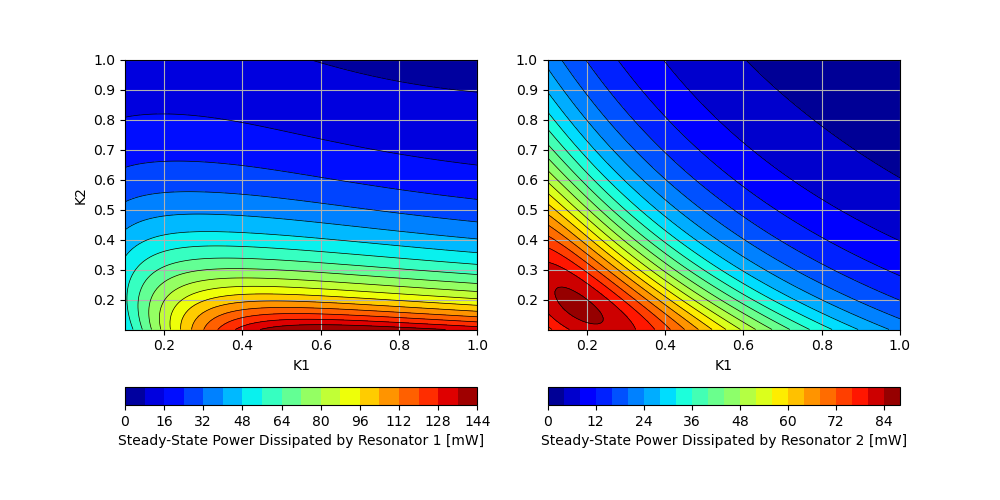

In [76]:
fig = plt.figure(figsize=(10, 5))
ax0 = fig.add_subplot(121)
plt.contourf(K1v, K2v, P2[:, :, 0].T * 1.0e3, levels=20, cmap="jet")
plt.colorbar(
    label="Steady-State Power Dissipated by Resonator 1 [mW]", orientation="horizontal"
)
plt.contour(K1v, K2v, P2[:, :, 0].T * 1.0e3, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
plt.ylabel("K2")
plt.grid()
ax1 = fig.add_subplot(122)
plt.contourf(K1v, K2v, P2[:, :, 1].T * 1.0e3, levels=20, cmap="jet")
plt.colorbar(
    label="Steady-State Power Dissipated by Resonator 2 [mW]", orientation="horizontal"
)
plt.contour(K1v, K2v, P2[:, :, 1].T * 1.0e3, levels=20, colors="black", linewidths=0.5)
plt.xlabel("K1")
# plt.ylabel("K2")
plt.grid()
plt.show()

C'est beau mais assez étrange. A discuter !